# Main Project 1 - 폐렴 진단기 성능개선

In [1]:
import os, re
import random, math

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings(action='ignore')

### (1) 실습환경 준비

In [2]:
BATCH_SIZE = 16
EPOCHS = 20

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
TRAIN_PATH = './data/train/*/*'
VAL_PATH = './data/val/*/*'
TEST_PATH = './data/test/*/*'

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### (2) 데이터 전처리

- train, val 분리

In [5]:
# train 데이터와 validation 데이터 합치기
filenames = train_filenames
filenames.extend(val_filenames)

# filenames를 8:2로 split
random.seed(8)
random.shuffle(filenames)

train_size = math.floor(len(filenames)*0.8)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
# sample 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
./data/train/NORMAL/NORMAL2-IM-1025-0001.jpeg
Pneumonia image path
./data/train/PNEUMONIA/person81_virus_152.jpeg


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
print(train_list_ds, val_list_ds)

<TensorSliceDataset shapes: (), types: tf.string> <TensorSliceDataset shapes: (), types: tf.string>


- train, val dataset 이미지 변환 및 label 추가

In [8]:
def get_label(file_path): # 파일 경로 끝에서 두번째 부분: NORMAL or PNEUMONIA
    parts = tf.strings.split(file_path, os.path.sep)
    return int(parts[-2] == "PNEUMONIA")   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

In [10]:
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# sample 확인
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  0


- test dataset 이미지 변환 및 label 추가

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print(f"Testing images count: {TEST_IMG_COUNT}")

Testing images count: 624


In [15]:
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

- data augmentation 및 이미지 배치 구성

In [16]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### (3) 데이터 시각화

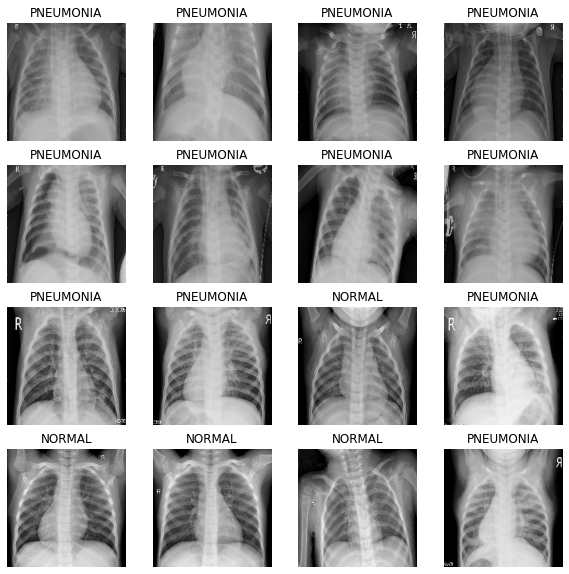

In [18]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### (4) ResNet-18 구현

In [ ]:
# class ResBlock(tf.keras.layers.Layer):
#     def __init__(self, n_filters, use_res=):
#         super().__init__()
           
#         self.conv1 = layers.SeparableConv2D(filters, 3, padding='same')
#         self.bn1 = layers.BatchNormalization()
#         self.relu = layers.Activation('relu')
#         self.conv2 = layers.SeparableConv2D(filters, 3, padding='same')
#         self.bn2 = layers.BatchNormalization()
        
#         self.merge = layers.Add()

#     def call(self, inputs):
#         res = inputs
        
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv1(inputs)
#         x = self.bn1(x)
        
#         if self.use_bn:
#             x = self.batchnorm(x)
#         return self.lrelu(x)

In [ ]:
    
# class DecodeBlock(layers.Layer):
#     def __init__(self, f, dropout=True):
#         super(DecodeBlock, self).__init__()
#         self.dropout = dropout
#         self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
#         self.batchnorm = layers.BatchNormalization()
#         self.relu = layers.ReLU()
        
#     def call(self, x):
#         x = self.Transconv(x)
#         x = self.batchnorm(x)
#         if self.dropout:
#             x = layers.Dropout(.5)(x)
#         return self.relu(x)

In [ ]:
# def conv_block(x, filters):
#     block = tf.keras.Sequential([
#         tf.keras.layers.Conv2D(filters[0], 3, strides=2, padding='same'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Activation('relu'),
#         tf.keras.layers.Conv2D(filters[1], 3, padding='same'),
#         tf.keras.layers.BatchNormalization()
#     ])
    
#     return block

In [19]:
def conv_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters[0], 3, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters[1], 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    down = tf.keras.layers.Conv2D(filters[1], 1, strides=2, padding='same')(inputs)
    down = tf.keras.layers.BatchNormalization()(down)
    
    x = tf.keras.layers.add([x, down])
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [20]:
def identity_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters[0], 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters[1], 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.add([x, inputs])
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [30]:
def resnet18():
    img_input = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(img_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = conv_block(x, [64, 64])
    x = identity_block(x, [64, 64])
    
    x = conv_block(x, [128, 128])
    x = identity_block(x, [128, 128])
    
    x = conv_block(x, [256, 256])
    x = identity_block(x, [256, 256])
    
    x = conv_block(x, [512, 512])
    x = identity_block(x, [512, 512])
    
    x = tf.keras.layers.AveragePooling2D(7, padding='same')(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(1, activation='softmax')(x)
    
    return tf.keras.models.Model(img_input, x, name='resnet18')

In [43]:
# def resnet18():
#     x = 
#     model = tf.keras.Sequential([
#         tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), batch_size=BATCH_SIZE),
        
#         tf.keras.layers.Conv2D(64, 7, strides=2, padding='same'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        
#         residual_block(64),
#         residual_block(64),
        
#         residual_block(128),
#         residual_block(128),
        
#         residual_block(256),
#         residual_block(256),
        
#         residual_block(512),
#         residual_block(512),
        
#         tf.keras.layers.AveragePooling2D(7, padding='same'),
        
#         tf.keras.layers.Flatten(),
        
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    
#     return model

In [31]:
with tf.device('/GPU:0'):
    model = resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    model.summary()

Model: "resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 90, 90, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 90, 90, 64)   256         conv2d_63[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 45, 45, 64)   0           batch_normalization_63[0][0]     
___________________________________________________________________________________________

### (5) 데이터 imbalance 처리

In [23]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [24]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### (6) 모델 훈련

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 123s 402ms/step - loss: 0.2409 - accuracy: 0.7445 - precision: 0.7445 - recall: 1.0000 - val_loss: 0.6487 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 69s 266ms/step - loss: 0.1381 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 0.1828 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 51s 195ms/step - loss: 0.1060 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 52s 200ms/step - loss: 0.0926 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 0.1669 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 5/20
261/261 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.

### (7) 결과 확인 및 시각화

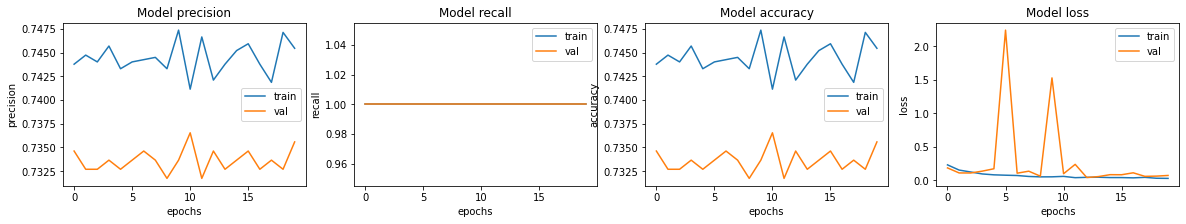

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 118ms/step - loss: 0.9246 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.9245890378952026,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
